<a href="https://colab.research.google.com/github/aachen6/deepTC/blob/master/colab/deepTC_image_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepTC - Prediction

The objective of *deepTC* can be found on [deepTC github page](https://github.com/aachen6/deepTC/), and the analysis is outlined below.
1. Data Preprocess
 - 1.1 [Satellite images and tracks of TC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_sync.ipynb)
 - 1.2 [Statistics of satellite images and tracks](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_stats.ipynb)

2. Model for TC Image
 - 2.1 [Post-binding architecture of TC image](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_image.ipynb)
 - 2.2 [CNN model for TC image classification ](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_cnn5.ipynb)
 - 2.3 [Resnet model for TC image classification](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb)
 - 2.4 [Resnet model for TC image intensity estimation](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_intensity_resnet.ipynb)
 - **2.5 [Operation of TC image prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_image_prediction.ipynb)**

3. Model for TC Track
 - 3.1 [Post-binding architecture of TC track](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_track.ipynb)
 - 3.2 [LSTM model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb)
 - 3.3 [LSTM model with attension for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb) 
 - 3.4 [LSTM-CNN model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstmcnn.ipynb)

4. Generative Model for TC Image
 - 4.1 [DCGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_generative_dcgan.ipynb)
 - 4.2 [SAGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_generative_sagan.ipynb)

We developed and trained *Resnet* models for TC satellite image [classification](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb) and [intensity estimation](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_intensity_resnet.ipyn). In this notebook, let's put those models into operation and demonstrate the application of the model.

In [0]:
!pip install import-ipynb

In [0]:
import os 
import yaml
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

work_dir = r'/content/drive/My Drive/Colab Notebooks/deepTC'

# load class defined in other ipynb
import import_ipynb
model_ipynb = work_dir + os.sep + 'deepTC_net_image.ipynb'
with open(model_ipynb, 'rb') as fp:
    with open('deepTC_net_lib.ipynb','wb') as fout:
       fout.write(fp.read())
  
import deepTC_net_lib
# force reload in case of error 
#import importlib  
#importlib.reload(deepTC_net_lib)
from deepTC_net_lib import YML2ModelNet, ImageDataSet, ImageTrainer, ImageInference


Firstly, trained models for TC image classification and intensity estimation are loaded from the saved file containing pytorch state dictionary, which are used to make prediction of the satellite image. This is achieved by using the inference class we defined earlier [here](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_image.ipynb).

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms

p_data  = work_dir + os.sep + 'data/AL'
p_image = work_dir + os.sep + 'image/AL'
p_model_cls = work_dir + os.sep + 'model/tc_classification/resnet'
p_model_int = work_dir + os.sep + 'model/tc_intensity'

# classification
f_config = p_model_cls + os.sep + 'config_resnet.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)
config['params']['f_model_pth'] = p_model_cls + os.sep + config['params']['f_model_pth']  
model_cls = ImageInference(config, 'resnet')

# load one hot vector 
f_data_yml = p_model_cls + os.sep +  config['params'] ['f_data_yml'] 
with open(f_data_yml, 'rb') as fp: data = yaml.load(fp)    
one_hot_key   = data['one_hot_key']
one_hot_rev   = data['one_hot_rev']

# intensity
f_config = p_model_int + os.sep + 'config_resnet_regression.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)
config['params']['f_model_pth'] = p_model_int + os.sep + config['params']['f_model_pth']
model_int = ImageInference(config, 'resnet')
      
image_transforms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.456,), (0.222,))])



The infared satellite image is available online from [NRL](https://www.nrlmry.navy.mil/tcdat/), which will be tranformed to the same size as the training data. 

In [0]:
###@title Number fields
URL = 'https://www.nrlmry.navy.mil/tcdat/tc05/ATL/12L.KATRINA/ir/geo/1km_bw/20050828.1200.goes10.x.ir1km_bw.12LKATRINA.140kts-908mb-257N-877W.jpg' #@param {type:'string'}

import requests
from io import BytesIO
from PIL import Image

try: 
  response = requests.get(URL, stream=True)
  sample   = Image.open(BytesIO(response.content))
  sample   = sample.crop((64, 64, 960, 960))
  sample   = sample.resize((256,256))
except:
  print ('Wrong URL:', URL)
  
  

As an exmaple, a snap shot is taken from Katrina that caused catastrophic damage from central Florida to eastern Texas, and the model predicts it to be a category 5 hurricane with a high confidence of 99.2% and the corresponding wind speed of 139.3 knots that matches perfectly with the NHC designation. Admittedly, this is 'cheating' as this image may be used in the training. However, the test dataset demonstrated the performance of the model. This simply shows how the trained model can be applied. It should be noted that the model does not generalize well to a different image set, i.e. visible image, storms centered differently etc., since no data augmentation is used during the training. Without data augmentation, the model is currently limited to IR images similar to that from NRL. However, this can be applied to future storm events.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.793616533279419, 0.09999999999999998, '139.3 knots, 99.2%')

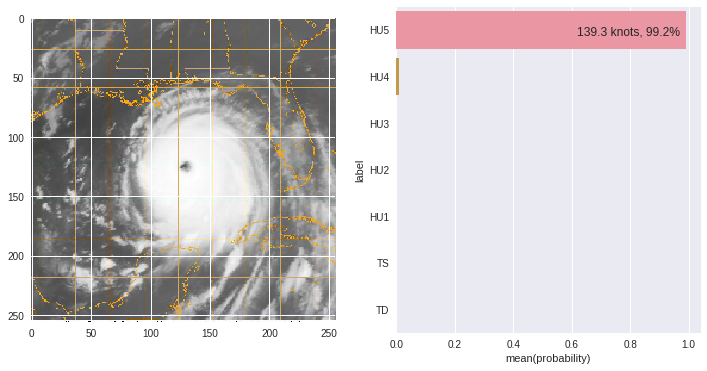

In [0]:
'''
row = pd_storm[pd_storm[b'key']=='AL200518RITA09220845'].iloc[0]
cat = row[b'cat']
image = row[b'image'].decode('utf-8')
temp = image.split('.')[0].split('_')
f_image = temp[0] + '_' + temp[1] + '.jpg'
sample = Image.open(img_archv.open(f_image))     
'''

img_tensor = image_transforms(sample)
img_tensor = img_tensor.unsqueeze(0)

predict_cls = model_cls.inference(img_tensor, True)

mean = 60.9;   std  = 26.9
predict_int = model_int.inference(img_tensor, False)
predict_int = predict_int[0][0]*std + mean

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))  
ax1.imshow(sample)

cats = ['HU5','HU4','HU3','HU2','HU1','TS','TD']
#data = [[value, predict_cls[0][key]] for key, value in one_hot_rev.items()]
data = [[cat, predict_cls[0][one_hot_key[cat]]] for cat in cats]
(w, i) =max((w[1], i) for i, w in enumerate(data))

df_predict = pd.DataFrame(data, columns=['label','probability'])
sns.barplot(x='probability', y='label', data=df_predict, ax=ax2)

p = ax2.patches[i]

ax2.text(0.8*p.get_width(), p.get_y()+0.5, \
   '{0:.1f} knots, {1:.1f}%'.format(predict_int, w*100), ha="center")
